In [33]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

import qiskit
from qiskit.tools.visualization import circuit_drawer, plot_histogram, plot_state
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, QuantumProgram
from qiskit import available_backends, execute

In [34]:
%load_ext autoreload
%autoreload 2
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


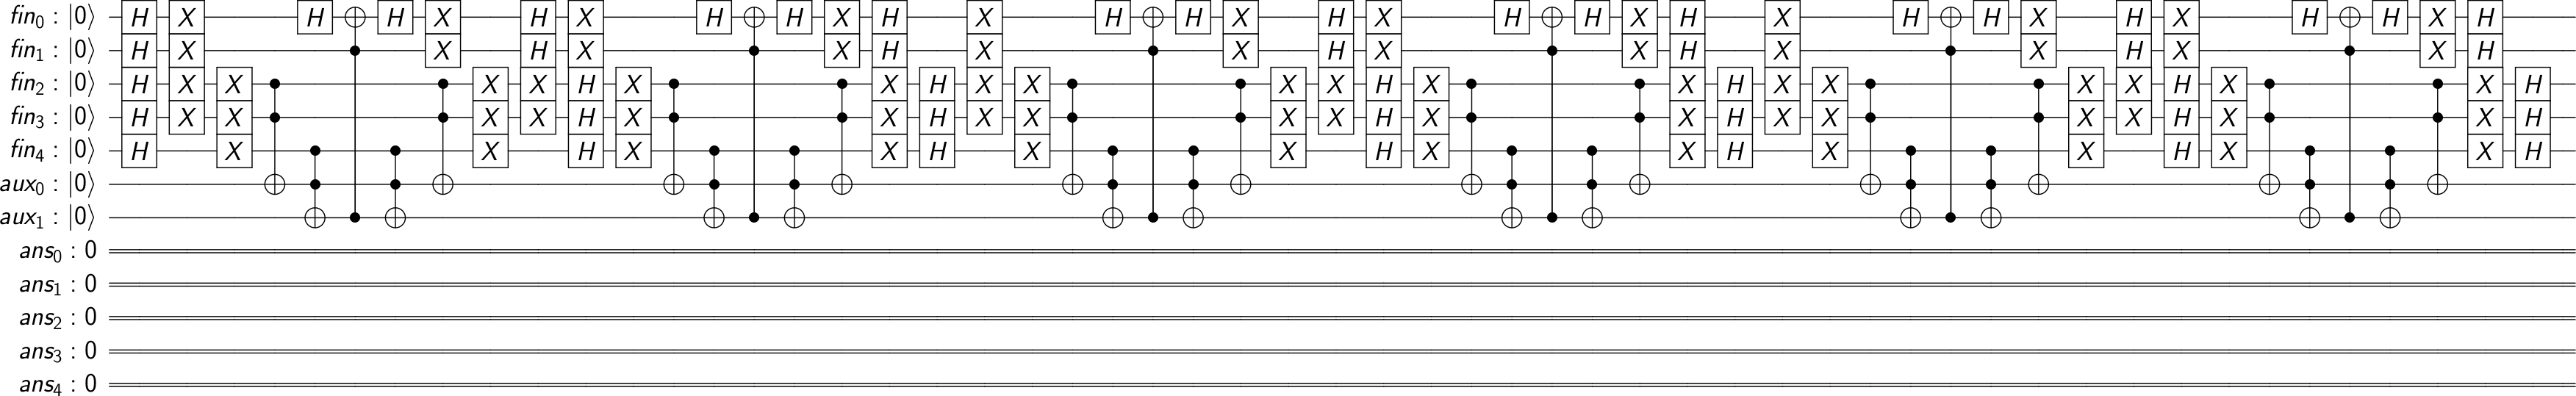

In [99]:
n = 5  # Number of qubits.
string = [0,0,1,1,0]
def build_oracle(qc, f_in, aux, string):
    for i in range(len(f_in)):
        if string[i]==1:
            qc.x(f_in[i])
    
    target = f_in[0]
    controls = [f_in[i] for i in range(1, n)]
    
    qc.x(f_in)
    n_controlled_Z(qc, controls, target, aux)
    qc.x(f_in)
    
    for i in range(len(f_in)):
        if string[i]==1:
            qc.x(f_in[i])

    return qc
    
    
# Building Grover's diffusion operator
def build_diffusion_operator(qc, f_in, aux):
    target = f_in[0]
    controls = [f_in[i] for i in range(1, n)]
    
    qc.h(f_in)
    qc.x(f_in)
    n_controlled_Z(qc, controls, target, aux)
    qc.x(f_in)
    qc.h(f_in)
    return qc

def build_grover_search_qc(n, n_iter, string):
    assert(len(string)==n)
    
    f_in = QuantumRegister(n, name='fin')
    c = ClassicalRegister(n, name='ans')
    
    aux = None
    qc = None
    # len(controls) = n - 1
    if n > 3:
        aux = QuantumRegister(n - 3, name='aux')
        qc = QuantumCircuit(f_in, aux, c, name='grover')
    else:
        qc = QuantumCircuit(f_in, c, name='grover')
    
    # preparing uniform superposition
    qc.h(f_in)
    
    for i in range(n_iter):
        qc = build_oracle(qc, f_in, aux, string)
        qc = build_diffusion_operator(qc, f_in, aux)
    ans = ClassicalRegister(n, name='ans')
    #qc.measure(f_in,ans) #uncomment if want to run measurements at the end
    return qc

n_iter = int ( np.sqrt(n) + 1 ) # iterate sqrt(N) times
qc = build_grover_search_qc(n, n_iter, string)
circuit_drawer(qc)

In [100]:
statevector = execute(qc, backend='local_statevector_simulator_py', shots=1).result().get_data()['statevector']
statevector = statevector[:2 ** n]
statevector

array([-0.05765959+8.01280145e-16j, -0.05765959+5.68428969e-16j,
       -0.05765959+7.18416639e-16j, -0.05765959+7.00670802e-16j,
       -0.05765959+7.95644404e-16j, -0.05765959+7.13912170e-16j,
       -0.05765959+7.11974456e-16j, -0.05765959+7.71075314e-16j,
       -0.05765959+8.30338873e-16j, -0.05765959+6.88150373e-16j,
       -0.05765959+7.88302289e-16j, -0.05765959+7.08519411e-16j,
       -0.94706733+1.18604109e-14j, -0.05765959+6.23936236e-16j,
       -0.05765959+6.69844382e-16j, -0.05765959+6.30932508e-16j,
       -0.05765959+7.25558778e-16j, -0.05765959+6.99229112e-16j,
       -0.05765959+7.44132978e-16j, -0.05765959+7.26879906e-16j,
       -0.05765959+8.43610195e-16j, -0.05765959+7.81497387e-16j,
       -0.05765959+7.69524844e-16j, -0.05765959+7.23116253e-16j,
       -0.05765959+7.53404574e-16j, -0.05765959+7.54048777e-16j,
       -0.05765959+6.09930284e-16j, -0.05765959+6.81873318e-16j,
       -0.05765959+6.76986521e-16j, -0.05765959+7.13805849e-16j,
       -0.05765959+5.7066

You can check results [here](http://algassert.com/quirk#circuit={"cols":[["H","H","H","H"],["Z","•","•","•"],["H","H","H","H"]]}).

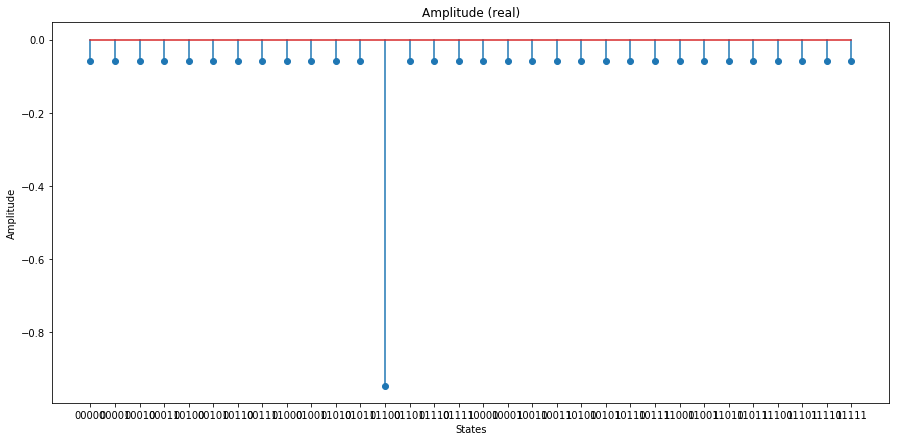

In [101]:
plt.figure(figsize=(15, 7))
x = np.arange(1, 1 + 2 ** n)
states = list(map(lambda x: ''.join(map(str, x)), itertools.product([0, 1], repeat=n)))
plt.stem(x, statevector.real)
plt.xticks(x, states)
plt.title('Amplitude (real)')
plt.xlabel('States')
plt.ylabel('Amplitude')
plt.show()

# Grover only

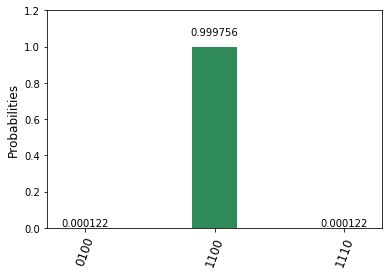

In [85]:
#qc.measure(f_in, ans)
problem = execute(qc, backend='local_qasm_simulator', shots=8192)
print(problem)
result = problem.result()
counts = result.get_counts()
plot_histogram(counts)
result

# k-SAT

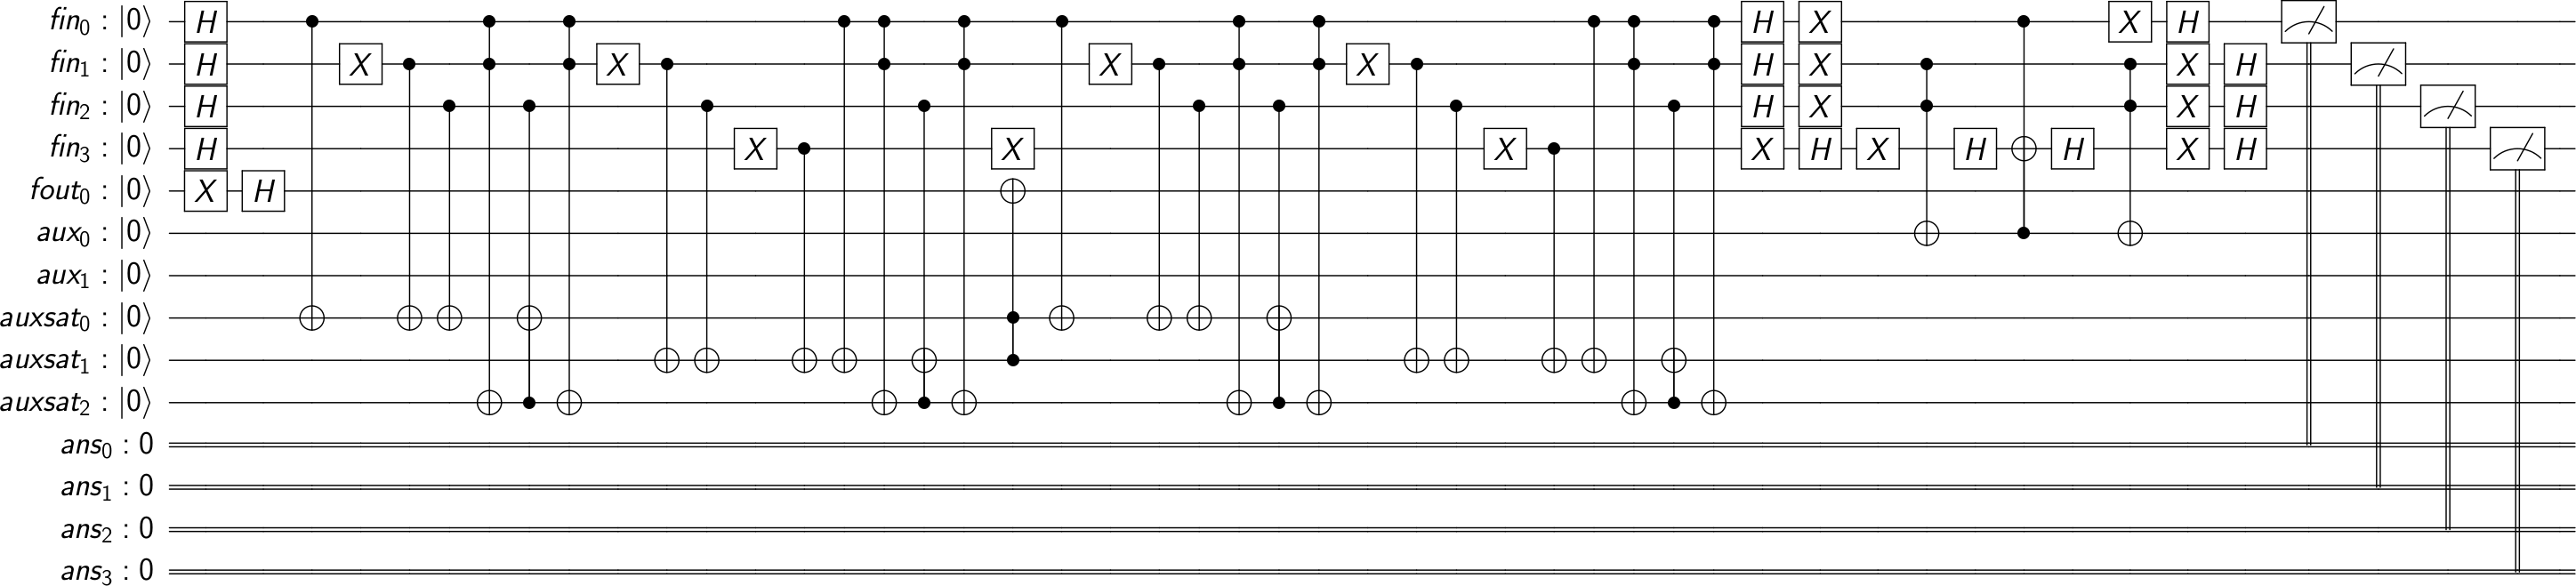

In [69]:
n = 4  # Number of qubits.
sat_formula = [[1, -2, 3], [2, 3, -4, 1]]

f_in = QuantumRegister(n, name='fin')
f_out = QuantumRegister(1, name='fout')
aux_sat = QuantumRegister(len(sat_formula) + 1, name='auxsat')
ans = ClassicalRegister(n, name='ans')

n_controls = n

aux = None
qc = None
if n_controls > 2:
    aux = QuantumRegister(n_controls - 2, name='aux')
    qc = QuantumCircuit(f_in, f_out, aux, aux_sat, ans, name='grover')
else:
    qc = QuantumCircuit(f_in, f_out, aux_sat, ans, name='grover')

input_state(qc, f_in, f_out)
black_box_u_f(qc, f_in, f_out, aux_sat, n, sat_formula)
inversion_about_average(qc, f_in, aux, n)

qc.measure(f_in, ans)

circuit_drawer(qc)

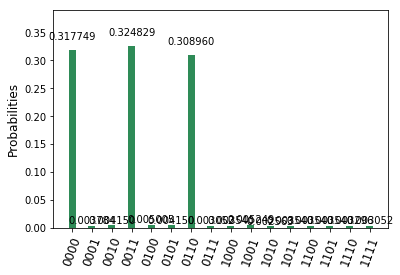

In [70]:
result = execute(qc, backend='local_qasm_simulator', shots=8192).result()
counts = result.get_counts('grover')
plot_histogram(counts)